The Internet has not only made information accessible to the masses but also has become a hotspot of misinformation and fake news. Fake news can lead to more harm if not correctly identified and tagged. The severity of of the effects of misinformation can be judged from the fact that there have been riots and killings attributed to fake news.

Fake news can even sway people's opinions and affiliations - a fact that political parties have used (and still use) to make people vote in their favour.

As such, it has become necessary to segregate the real from the fake news. But this is not feasible manually thanks to the huge amount of information that is churned out every minute on the internet.

To overcome this problem, machine learnng and natural languaging processing can be to automatically classify the fake from the real news.

# Overview
In this project, I've tried to classify the given news as fake or real, by using Naive Bayes classifier and Passive Aggressive Classifier. I tried using Naive Bayes with hyperparameter tuning. 

The best result was given by Passive Aggressive Classifier, with an accuracy of over 99.5%

# Importing necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import itertools
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

# Dataset
The [dataset used here](https://www.kaggle.com/pnkjgpt/fake-news-dataset) consists of a train and a test file. The test file can be ignored as it doesn't contain the labels (as I'm doing this project as a part of a competition). We will work only on the train data.

The train dataset contains 7 columns - **'index', 'title', 'text', 'subject', 'date', 'class', 'Unnamed: 6'**

In [2]:
train = pd.read_csv('../input/fake-news-dataset/train.csv')
train.head()

,index,title,text,subject,date,class,Unnamed: 6
0,0,PRESIDENT TRUMP Explains New “America First” R...,That s what we re talking about! Another campa...,politics,"Aug 2, 2017",Fake,NaN
1,1,TERMINALLY ILL FORMER MISS WI: “Until my last ...,How is it that Sean Hannity is the only media ...,politics,"Oct 4, 2016",Fake,NaN
2,2,Cruz Humiliated By Moderator After Lie About ...,Almost immediately after learning that longtim...,News,"February 13, 2016",Fake,NaN
3,3,"Russia revels in Trump victory, looks to sanct...",MOSCOW (Reuters) - For all their mutual praise...,politicsNews,"November 9, 2016",Real,NaN
4,4,Trump's bid to open U.S. monuments to developm...,WASHINGTON (Reuters) - The Trump administratio...,politicsNews,"May 26, 2017",Real,NaN


In [3]:
train.head()

,index,title,text,subject,date,class,Unnamed: 6
0,0,PRESIDENT TRUMP Explains New “America First” R...,That s what we re talking about! Another campa...,politics,"Aug 2, 2017",Fake,NaN
1,1,TERMINALLY ILL FORMER MISS WI: “Until my last ...,How is it that Sean Hannity is the only media ...,politics,"Oct 4, 2016",Fake,NaN
2,2,Cruz Humiliated By Moderator After Lie About ...,Almost immediately after learning that longtim...,News,"February 13, 2016",Fake,NaN
3,3,"Russia revels in Trump victory, looks to sanct...",MOSCOW (Reuters) - For all their mutual praise...,politicsNews,"November 9, 2016",Real,NaN
4,4,Trump's bid to open U.S. monuments to developm...,WASHINGTON (Reuters) - The Trump administratio...,politicsNews,"May 26, 2017",Real,NaN


In [4]:
train.shape

(40000, 7)

**Checking for null values**

In [5]:
train.isnull().sum()

index             0
title             0
text              0
subject           0
date              0
class             0
Unnamed: 6    39999
dtype: int64

**Checking whether the dataset is balanced or imbalanced**

In [6]:
train['class'].value_counts()

Fake                20886
Real                19113
February 5, 2017        1
Name: class, dtype: int64

The dataset is fairly balanced with the number of Real and Fake classes almost equal. 

Their seems to be another class with the name **'February 5, 2017'** consisting of only one data point. On further inspection, I find that the features for this data point has been shifted one column ahead for all the features. Since it is just one point, it can be removed or the features shifted in the reverse direction. 

I chose to shift the columns in the right places.

In [7]:
train[train['class'] == 'February 5, 2017']

,index,title,text,subject,date,class,Unnamed: 6
504,504,Even Mitch McConnell Is Beginning To Turn On ...,Is Impeachment Next? (VIDEO),Donald Trump s Muslim ban is proving to be a l...,News,"February 5, 2017",Fake


In [8]:
#shifting the column values in the respective places
train.iloc[504, 2] = train.iloc[504, 3]
train.iloc[504, 3] = train.iloc[504, 4]
train.iloc[504, 4] = train.iloc[504, 5]
train.iloc[504, 5] = train.iloc[504, 6]
train.iloc[504, 6] = np.nan

In [9]:
train.iloc[[504]]

,index,title,text,subject,date,class,Unnamed: 6
504,504,Even Mitch McConnell Is Beginning To Turn On ...,Donald Trump s Muslim ban is proving to be a l...,News,"February 5, 2017",Fake,NaN


The **index** and **Unnamed: 6** columns can now be removed as these are redundant and don't convey any information.

In [10]:
train.drop(['index', 'Unnamed: 6'], axis = 1, inplace=True)
train.head()

,title,text,subject,date,class
0,PRESIDENT TRUMP Explains New “America First” R...,That s what we re talking about! Another campa...,politics,"Aug 2, 2017",Fake
1,TERMINALLY ILL FORMER MISS WI: “Until my last ...,How is it that Sean Hannity is the only media ...,politics,"Oct 4, 2016",Fake
2,Cruz Humiliated By Moderator After Lie About ...,Almost immediately after learning that longtim...,News,"February 13, 2016",Fake
3,"Russia revels in Trump victory, looks to sanct...",MOSCOW (Reuters) - For all their mutual praise...,politicsNews,"November 9, 2016",Real
4,Trump's bid to open U.S. monuments to developm...,WASHINGTON (Reuters) - The Trump administratio...,politicsNews,"May 26, 2017",Real


# Data description

In [11]:
train.describe(include = 'all').T

,count,unique,top,freq
title,40000,35075,Factbox: Trump fills top jobs for his administ...,12
text,40000,34965,,552
subject,40000,8,politicsNews,10075
date,40000,2388,"December 20, 2017",161
class,40000,2,Fake,20887


From the above table, it can be seen that out of 40,000 titles and texts, 35,075 and 34,965 are unique, respectively.

So the remaining non-unique titles and texts must be removed. I removed the **text**, as it has more non-unique values comapred to **title**.

In [12]:
train.drop_duplicates(subset = ['text'], inplace=True)
train.reset_index(drop = True, inplace = True)
train.describe(include = 'all').T

,count,unique,top,freq
title,34965,34653,Factbox: Trump fills top jobs for his administ...,12
text,34965,34965,Michelle Obama told Oprah Winfrey in her final...,1
subject,34965,8,politicsNews,10023
date,34965,2388,"December 6, 2017",149
class,34965,2,Real,18936


As can be seen, out of 34,965 texts, 34,653 are unique. The remaining 312 (34965-34653) are non-unique. Since it's a small number, I let it as it is.

# Pie chart showing the type of articles

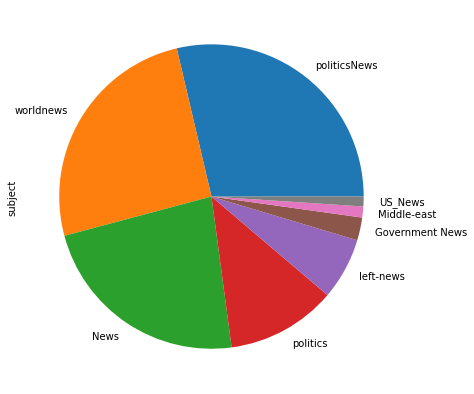

In [13]:
train['subject'].value_counts().plot.pie(figsize = (7, 7));

# Removing stopwords

In [14]:
import re
from nltk.corpus import stopwords

def stopwordsRemover(document):
    corpus = []
    for i in range(len(train)):
        temp = re.sub('[^a-zA-Z]', ' ', document[i])
        temp = temp.lower()
        temp = temp.split()

        temp = [word for word in temp if not word in stopwords.words('english')]
        temp = ' '.join(temp)
        corpus.append(temp)
    return(corpus)
noStopWordTitle = stopwordsRemover(train['title'])
noStopWordText = stopwordsRemover(train['text'])

In [15]:
#first 10 titles
noStopWordTitle[:10]

['president trump explains new america first raise act welfare new immigrants migrants favors english speaking immigrants protects jobs minorities us workers replaced video',
 'terminally ill former miss wi last breath use voice tell mr trump really video',
 'cruz humiliated moderator lie presidents appointing justices election year',
 'russia revels trump victory looks sanctions relief',
 'trump bid open u monuments development draws calls protection',
 'unreal ice released deport criminal illegals video',
 'consequences liberal tolerance isis flag hanging roof yet one reported video',
 'u news world report publishes list top popular nations refugees want live',
 'trump administration nafta demands make sense union pacific ceo',
 'turks flock social media gold trader sanctions case']

I removed the **title** and **text** and inserted the **noStopWordTitle** and **noStopWordText** in the dataframe

In [16]:
train.insert(0, 'noStopWordTitle', noStopWordTitle, True)
train.insert(1, 'noStopWordText', noStopWordText, True)

In [17]:
train.drop(['title', 'text'], axis = 1, inplace = True)

In [18]:
train.head()

,noStopWordTitle,noStopWordText,subject,date,class
0,president trump explains new america first rai...,talking another campaign promise kept wonder d...,politics,"Aug 2, 2017",Fake
1,terminally ill former miss wi last breath use ...,sean hannity media personality able find amazi...,politics,"Oct 4, 2016",Fake
2,cruz humiliated moderator lie presidents appoi...,almost immediately learning longtime supreme c...,News,"February 13, 2016",Fake
3,russia revels trump victory looks sanctions re...,moscow reuters mutual praise russian president...,politicsNews,"November 9, 2016",Real
4,trump bid open u monuments development draws c...,washington reuters trump administration call o...,politicsNews,"May 26, 2017",Real


# Top unigrams, bigrams and trigrams used in the title

Separating the Fake and Real titles

In [19]:
fakeTitles = train.noStopWordTitle[train['class'] == 'Fake']
realTitles = train.noStopWordTitle[train['class'] == 'Real']

mergedFake = ' '.join(fakeTitles)
mergedReal = ' '.join(realTitles)

In [20]:
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

def ngramFunct(corpus, n):
    token = nltk.word_tokenize(corpus)
    ans = ngrams(token,n)
    return(Counter(ans))

### Unigrams

In [21]:
unigramReal = ngramFunct(mergedReal, 1)
unigramFake = ngramFunct(mergedFake, 1)
ufreqReal = (nltk.FreqDist(unigramReal))
ufreqFake = (nltk.FreqDist(unigramFake))

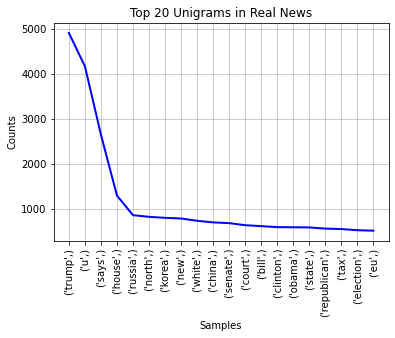

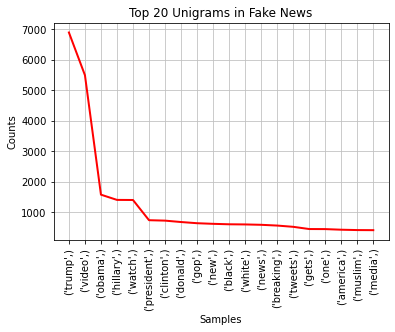

In [22]:
plt.title('Top 20 Unigrams in Real News')
ufreqReal.plot(20, cumulative=False, color = 'b');

plt.title('Top 20 Unigrams in Fake News')
ufreqFake.plot(20, cumulative=False, color = 'r');

### Bigrams

In [23]:
bigramReal = ngramFunct(mergedReal, 2)
bigramFake = ngramFunct(mergedFake, 2)
bfreqReal = (nltk.FreqDist(bigramReal))
bfreqFake = (nltk.FreqDist(bigramFake))

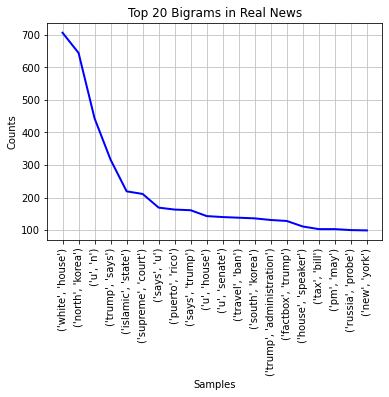

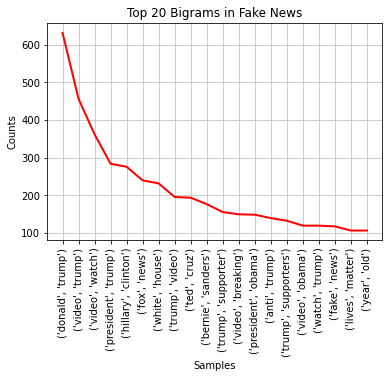

In [24]:
plt.title('Top 20 Bigrams in Real News')
bfreqReal.plot(20, cumulative=False, color = 'b');

plt.title('Top 20 Bigrams in Fake News')
bfreqFake.plot(20, cumulative=False, color = 'r');

### Trigrams

In [25]:
trigramReal = ngramFunct(mergedReal, 3)
trigramFake = ngramFunct(mergedFake, 3)
tfreqReal = (nltk.FreqDist(trigramReal))
tfreqFake = (nltk.FreqDist(trigramFake))

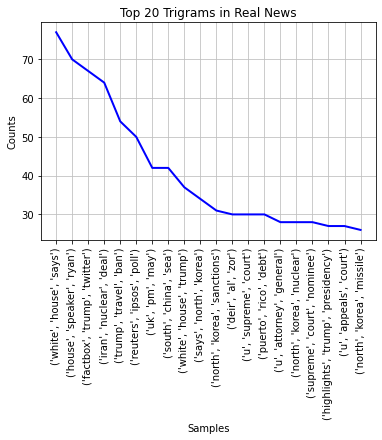

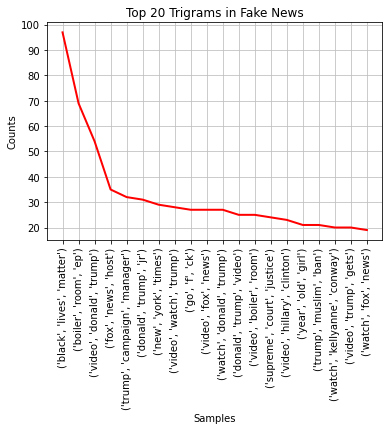

In [26]:
plt.title('Top 20 Trigrams in Real News')
tfreqReal.plot(20, cumulative=False, color = 'b');

plt.title('Top 20 Trigrams in Fake News')
tfreqFake.plot(20, cumulative=False, color = 'r');

# Model Building

I first tried to use the models on the titles only and then the text only and then merged the titles and text.

### Stemming the words

In [27]:
from nltk.stem.snowball import SnowballStemmer

def stem(data):    
    stemmer = SnowballStemmer('english')
    stemmed = []
    for i in range(len(data)):
        temp = data[i]
        temp = [stemmer.stem(word) for word in temp]
        temp = ''.join(temp)
        stemmed.append(temp)
    return(stemmed)

## Applying models to the Titles

In [28]:
titleCorpus = stem(train.noStopWordTitle)
titleCorpus[:10]

['president trump explains new america first raise act welfare new immigrants migrants favors english speaking immigrants protects jobs minorities us workers replaced video',
 'terminally ill former miss wi last breath use voice tell mr trump really video',
 'cruz humiliated moderator lie presidents appointing justices election year',
 'russia revels trump victory looks sanctions relief',
 'trump bid open u monuments development draws calls protection',
 'unreal ice released deport criminal illegals video',
 'consequences liberal tolerance isis flag hanging roof yet one reported video',
 'u news world report publishes list top popular nations refugees want live',
 'trump administration nafta demands make sense union pacific ceo',
 'turks flock social media gold trader sanctions case']

### TF-IDF

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = tf.fit_transform(titleCorpus).toarray()
y = train['class']

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33)

### Multinomial Naive Bayes

Accuracy : 0.929


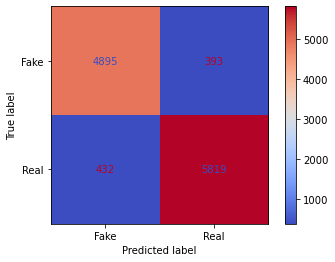

In [31]:
from sklearn.naive_bayes import MultinomialNB
classifierMNB = MultinomialNB()
classifierMNB.fit(X_train, y_train) 
pred = classifierMNB.predict(X_val)
score = metrics.accuracy_score(y_val, pred)
print('Accuracy : %0.3f' %score)

cm = plot_confusion_matrix(classifierMNB, X_val, y_val, cmap = 'coolwarm')

### Passive Aggressive Classifier

Accuracy : 0.912


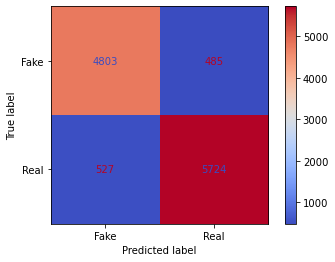

In [32]:
from sklearn.linear_model import PassiveAggressiveClassifier
classifierPAC = PassiveAggressiveClassifier(n_iter_no_change=50)
classifierPAC.fit(X_train, y_train)
pred = classifierPAC.predict(X_val)
score = metrics.accuracy_score(y_val, pred)
print('Accuracy : %0.3f'%score)
cm = plot_confusion_matrix(classifierPAC, X_val, y_val, cmap = 'coolwarm')

## Applying models to the Text

In [33]:
textCorpus = stem(train.noStopWordText)
textCorpus[:10]

['talking another campaign promise kept wonder democrats media allies fear president trump last time politician actually followed promise made american voters helped get elected president trump joined two republican senators wednesday champion legislation overhauling legal immigration america calling merit based system would significantly cut admissions next decade speaking white house president called significant reform immigration system half century candidate campaigned creating merit based immigration system protects u workers taxpayers today trump said joined georgia sen david perdue arkansas sen tom cotton republicans first introduced reforming american immigration strong economy raise act february said legislation aims reduce number green cards issued half million year trump perdue cotton argued tuesday low skilled unskilled immigration united states depressed wages according fact sheet released reporters new system would favor immigrants educated speak english high paying job o

## TF-IDF

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = tf.fit_transform(textCorpus).toarray()
y = train['class']

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33)

### Multinomial Naive Bayes

Accuracy : 0.950


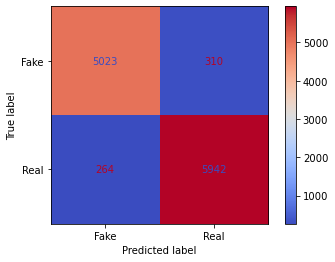

In [36]:
from sklearn.naive_bayes import MultinomialNB
classifierMNB = MultinomialNB()
classifierMNB.fit(X_train, y_train) 
pred = classifierMNB.predict(X_val)
score = metrics.accuracy_score(y_val, pred)
print('Accuracy : %0.3f' %score)

cm = plot_confusion_matrix(classifierMNB, X_val, y_val, cmap = 'coolwarm')

### Passive Aggressive Classifier

Accuracy : 0.992


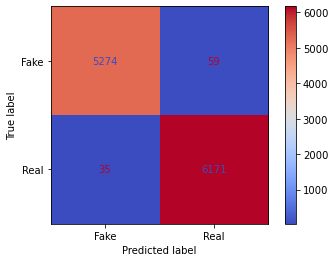

In [37]:
from sklearn.linear_model import PassiveAggressiveClassifier
classifierPAC = PassiveAggressiveClassifier(n_iter_no_change=50)
classifierPAC.fit(X_train, y_train)
pred = classifierPAC.predict(X_val)
score = metrics.accuracy_score(y_val, pred)
print('Accuracy : %0.3f'%score)
cm = plot_confusion_matrix(classifierPAC, X_val, y_val, cmap = 'coolwarm')

## Combining the Title and Text and applying Models

In [38]:
train['Title and Text'] = train[['noStopWordTitle', 'noStopWordText']].apply(' '.join, axis=1)
train.head()

,noStopWordTitle,noStopWordText,subject,date,class,Title and Text
0,president trump explains new america first rai...,talking another campaign promise kept wonder d...,politics,"Aug 2, 2017",Fake,president trump explains new america first rai...
1,terminally ill former miss wi last breath use ...,sean hannity media personality able find amazi...,politics,"Oct 4, 2016",Fake,terminally ill former miss wi last breath use ...
2,cruz humiliated moderator lie presidents appoi...,almost immediately learning longtime supreme c...,News,"February 13, 2016",Fake,cruz humiliated moderator lie presidents appoi...
3,russia revels trump victory looks sanctions re...,moscow reuters mutual praise russian president...,politicsNews,"November 9, 2016",Real,russia revels trump victory looks sanctions re...
4,trump bid open u monuments development draws c...,washington reuters trump administration call o...,politicsNews,"May 26, 2017",Real,trump bid open u monuments development draws c...


In [39]:
titleTextCorpus = stem(train['Title and Text'])
titleTextCorpus[:5]

['president trump explains new america first raise act welfare new immigrants migrants favors english speaking immigrants protects jobs minorities us workers replaced video talking another campaign promise kept wonder democrats media allies fear president trump last time politician actually followed promise made american voters helped get elected president trump joined two republican senators wednesday champion legislation overhauling legal immigration america calling merit based system would significantly cut admissions next decade speaking white house president called significant reform immigration system half century candidate campaigned creating merit based immigration system protects u workers taxpayers today trump said joined georgia sen david perdue arkansas sen tom cotton republicans first introduced reforming american immigration strong economy raise act february said legislation aims reduce number green cards issued half million year trump perdue cotton argued tuesday low ski

## TD-IDF

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = tf.fit_transform(titleTextCorpus).toarray()
y = train['class']

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33)

### Multinomial Naive Bayes

Accuracy : 0.953


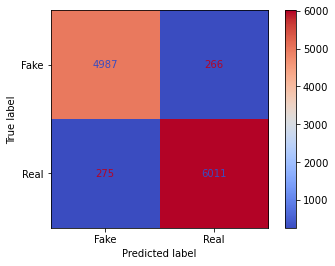

In [42]:
from sklearn.naive_bayes import MultinomialNB
classifierMNB = MultinomialNB()
classifierMNB.fit(X_train, y_train) 
pred = classifierMNB.predict(X_val)
score = metrics.accuracy_score(y_val, pred)
print('Accuracy : %0.3f' %score)

cm = plot_confusion_matrix(classifierMNB, X_val, y_val, cmap = 'coolwarm')

### Passive Aggressive Classifier

Accuracy : 0.993


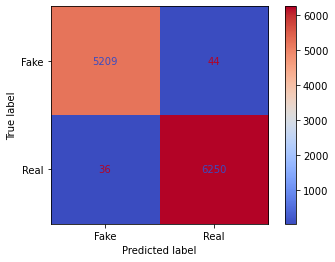

In [43]:
from sklearn.linear_model import PassiveAggressiveClassifier
classifierPAC = PassiveAggressiveClassifier(n_iter_no_change=50)
classifierPAC.fit(X_train, y_train)
pred = classifierPAC.predict(X_val)
score = metrics.accuracy_score(y_val, pred)
print('Accuracy : %0.3f'%score)
cm = plot_confusion_matrix(classifierPAC, X_val, y_val, cmap = 'coolwarm')

As it can be seen, the classification accuracy when the models are applied to the **titles** only is the least followed by the **text**.

The accuracy is highest when the **title** and **text** both are combined together. 

Compared with Naive Bayes, Passive Aggressive Classifier gives the best accuracy.

**Do upvote if this notebook helped you in learning something new.**

**Suggestions and discussions are welcome**